## 13. Tagging Task
* Tagging task: 자연어처리 분야에서 각 단어가 어떤 유형에 속해있는지를 알아냄
* 크게 2가지
1. 개체명 인식(Named Entity Recognition): 각 단어의 유형이 사람, 장소, 단체 등 어떤 유형인지를 알아냄
2. 품사 태깅(Part of Speech Tagging): 각 단어의 품사가 명사, 동사, 형용사인지를 알아냄
* Keras를 이용해서 인공 신경망을 이용한 개체명 인식기와 품사 태거를 만드는 미니 프로젝트 수행

### 1) 케라스를 이용한 태깅 작업 개요(Tagging Task using Keras)
* 이번 챕터에서는 케라스(Keras)로 인공 신경망을 이용하여 태깅 작업을 하는 모델을 만듦
* 개체명 인식기와 품사 태거. 두 작업의 공통점은 **RNN의 다-대-다(Many-to-Many)** 작업이면서 또한 앞, 뒤 시점의 입력을 모두 참고하는 **양방향 RNN(Bidirectional RNN)**을 사용한다는 점

#### 1. 훈련 데이터에 대한 이해
* 텍스트 분류 작업과 동일하게 지도 학습(Supervised learning)에 속함
* 태깅을 해야 하는 단어 데이터 X, 레이블에 해당되는 태깅 정보 데이터는 y 


* X와 y 데이터의 쌍(pair)는 병렬 구조를 가진다는 특성. X와 y의 각 데이터의 길이는 같음
* 각 데이터는 정수 인코딩 과정을 거친 후, 모든 데이터의 길이를 동일하게 맞춰주기 위한 패딩(Padding) 작업을 거침

#### 2. 시퀀스 레이블링(Sequence Labeling)
* 입력 시퀀스에 대하여 레이블 시퀀스를 각각 부여하는 작업을 Sequence Labeling Task라고 함

#### 3. 양방향 LSTM(Bidirectional LSTM)
> model.add(Bidirectional(LSTM(hidden_size, return_sequences=True)))

* 이전 시점의 단어 정보 뿐만 아니라 다음 시점의 단어 정보도 참고하기 위하여 bidirectional LSTM
* 인자 정보: 인자값을 하나 줄 경우에는 이는 hidden_size, 결과적으로 output_dim이 됨

#### 4. RNN의 다-대-다(Many-to-Many) 문제
* RNN의 은닉층은 모든 시점에 대해서 은닉 상태값을 출력할 수 있고, 마지막 시점에 대해서만 은닉 상태값을 출력할 수 있음
  * 이는 인자로 **return_sequences=True**를 넣을 것인지, 넣지 않을 것인지로 설정
  * 태깅 작업은 Many-to-Many로 True로 설정


## 2). 양방향 LSTM을 이용한 품사 태깅(Part-of-speech Tagging using Bi-LSTM)
* 2챕터 토큰화 챕터에서는 NLTK와 KoNLPy를 이용해서 이미 기존에 있는 모델로 품사 태깅을 수행했지만, 여기에서는 직접 양방향 LSTM을 이용한 품사 태깅을 수행하는 모델
### 1. 품사 태깅 데이터에 대한 이해와 전처리

In [29]:
!pip install nltk

In [30]:
import nltk
nltk.download('treebank')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


True

In [31]:
# 양방향 LSTM을 이용해서 품사 태깅을 하는 모델

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

* NLTK를 이용하면 영어 코퍼스에서 투큰화와 품사 태깅 전처리를 진행한 문장 데이터를 받아올 수 있음
* 여기서는 해당 데이터를 훈련시켜 품사 태깅을 수행하는 모델을 만듦

In [32]:
# 전체 문장 샘플의 개수 확인
tagged_sentences = nltk.corpus.treebank.tagged_sents() # 토큰화에 품사 태깅이 된 데이터 받아오기
print("품사 태깅이 된 문장 개수: ", len(tagged_sentences)) # 문장 샘플의 개수 출력

품사 태깅이 된 문장 개수:  3914


In [33]:
# 첫번째 샘플만 출력
print(tagged_sentences[0])

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


* 훈련을 시키려면 훈련 데이터에서 단어에 해당되는 부분과 품사 태깅 정보에 해당되는 부분은 분리시켜야 함. 
  * 즉, Pierre, Vinken 같이, NNP와 NNP 같이
  * 이런 경우, **zip()** 함수가 유용한 역할. **zip() 함수는 동일한 개수를 가지는 시퀀스 자료형에서 각 순서에 등장하는 원소끼리 묶어주는 역할**

In [34]:
sentences, pos_tags = [], []
for tagged_sentence in tagged_sentences: #3914개의 문장 샘플을 1개씩 불러옴
  sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 품사 태깅 정보들은 tag_info에 저장
  sentences.append(list(sentence)) #각 샘플에서 단어 정보만 저장
  pos_tags.append(list(tag_info)) #각 샘플에서 품사 태깅 정보만 저장

  #sentences.append(list(sentence))에서 list 없으면 ()로 묶임

In [ ]:
print(sentences[0])
print(pos_tags[0])

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']


샘플의 최대 길이 : 271
샘플의 평균 길이 : 25.722024


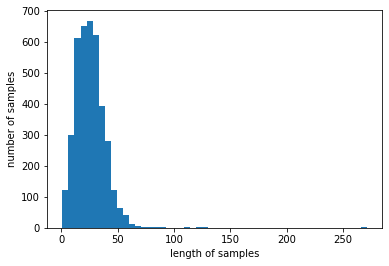

In [ ]:
# 전체 데이터의 길이 분포
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# 케라스 토크나이저를 다음과 같이 함수로 구현
def tokenize(samples):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(samples)
  return tokenizer

In [ ]:
# 문장 데이터에 대해서는 src_tokenizer, 레이블에 해당되는 품사 태깅 정보에 대해서는 tar_tokenizer 사용
src_tokenizer = tokenize(sentences)
tar_tokenizer = tokenize(pos_tags)

In [ ]:
# 단어 집합과 품사 태깅 정보 집합의 크기 확인
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 11388
태깅 정보 집합의 크기 : 47


In [ ]:
# 정수 인코딩
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(pos_tags)

In [ ]:
print(X_train[:2])
print(y_train[:2])

[[5601, 3746, 1, 2024, 86, 331, 1, 46, 2405, 2, 131, 27, 6, 2025, 332, 459, 2026, 3], [31, 3746, 20, 177, 4, 5602, 2915, 1, 2, 2916, 637, 147, 3]]
[[3, 3, 8, 10, 6, 7, 8, 21, 13, 4, 1, 2, 4, 7, 1, 3, 10, 9], [3, 3, 17, 1, 2, 3, 3, 8, 4, 3, 19, 1, 9]]


In [ ]:
# 샘플의 모든 길이를 임의로 150으로 맞춤
# 케라스의 pad_sequences()
max_len = 150
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

In [ ]:
# 모든 샘플의 길이가 150
# 이제 훈련 데이터 비율로 분리
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=777)

In [ ]:
# 레이블에 해당되는 태깅 정보에 대해서 원-핫 인코딩 수행
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [ ]:
# 각 데이터에 대한 크기 확인
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (3131, 150)
훈련 샘플 레이블의 크기 : (3131, 150, 47)
테스트 샘플 문장의 크기 : (783, 150)
테스트 샘플 레이블의 크기 : (783, 150, 47)


### 2. 양방향 LSTM(Bi-directional LSTM)으로 POS Tagger 만들기

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

In [ ]:
embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

TimeDistributed는 many 출력을 가진 모델에 사용
* 각 시간별로 출력되는 모든 출력값에 대해서 cost를 구해서 gradient를 구함

* one 출력 모델은 최종 출력 하나에서 gradient를 계산해 앞으로 보내고,
many의 경우는 중간 출력 결과에 대해서도 gradient 계산

In [ ]:
model.fit(X_train, y_train, batch_size=128, epochs=6, validation_data=(X_test, y_test))

Epoch 1/6
25/25 [==============================] - 46s 2s/step - loss: 0.5942 - accuracy: 0.1348 - val_loss: 0.5160 - val_accuracy: 0.1870
Epoch 2/6
25/25 [==============================] - 36s 1s/step - loss: 0.5036 - accuracy: 0.1915 - val_loss: 0.4810 - val_accuracy: 0.2184
Epoch 3/6
25/25 [==============================] - 36s 1s/step - loss: 0.4524 - accuracy: 0.3604 - val_loss: 0.4014 - val_accuracy: 0.4558
Epoch 4/6
25/25 [==============================] - 37s 1s/step - loss: 0.3407 - accuracy: 0.5173 - val_loss: 0.2744 - val_accuracy: 0.6004
Epoch 5/6
25/25 [==============================] - 36s 1s/step - loss: 0.2207 - accuracy: 0.6991 - val_loss: 0.1719 - val_accuracy: 0.7793
Epoch 6/6
25/25 [==============================] - 36s 1s/step - loss: 0.1277 - accuracy: 0.8526 - val_loss: 0.1044 - val_accuracy: 0.8709


In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

25/25 [==============================] - 3s 106ms/step - loss: 0.1044 - accuracy: 0.8709

 테스트 정확도: 0.8709


* 실제 맞추고 있는지를 특정 테스트 데이터를 주고 직접 출력해서 확인
* 인덱스로부터 단어와 품사 태깅 정보를 리턴하는 index_to_word와 index_to_tag를 만들고 이를 이용하여 실제값과 예측값을 출력

In [ ]:
index_to_word = src_tokenizer.index_word
index_to_tag = tar_tokenizer.index_word

i = 10 # 확인하고 싶은 테스트용 샘플 인덱스
y_predicted = model.predict(np.array([X_test[i]])) #입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함
true = np.argmax(y_test[i], -1) # 원핫 인코딩을 다시 정수 인코딩으로 변경

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_tag[t].upper(), index_to_tag[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
in               : IN      IN
addition         : NN      NN
,                : ,       ,
buick            : NNP     NNP
is               : VBZ     VBZ
a                : DT      DT
relatively       : RB      JJ
respected        : VBN     VBN
nameplate        : NN      NN
among            : IN      IN
american         : NNP     NNP
express          : NNP     NNP
card             : NN      NN
holders          : NNS     NNS
,                : ,       ,
says             : VBZ     VBZ
0                : -NONE-  -NONE-
*t*-1            : -NONE-  -NONE-
an               : DT      DT
american         : NNP     NNP
express          : NNP     NNP
spokeswoman      : NN      NN
.                : .       .


### 3. 양방향 LSTM + CRF(Bidirectional LSTM + CRF)로 POS Tagger 만들기
* 양방향 LSTM에 추가적으로 사용하면 성능을 높일 수 있다고 알려진 CRF layer를 추가하여 실습 진행
* tf2crf라는 패키지 설치

In [ ]:
!pip install tf2crf

     |████████████████████████████████| 1.1 MB 5.9 MB/s 


In [ ]:
# 이전 모델에 CRF layer를 추가한 새로운 모델 만들기
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, TimeDistributed, Dense, Input
from tf2crf import CRF, ModelWithCRFLoss

In [ ]:
inputs = Input(shape=(None, ), dtype='int32')
output = Embedding(vocab_size, 128, mask_zero=True)(inputs)
output = Bidirectional(LSTM(128, return_sequences=True))(output)
crf = CRF(tag_size) ##
output = crf(output) ##
base_model = Model(inputs, output)

model = ModelWithCRFLoss(base_model, sparse_target = False) ##
model.build(input_shape=(None, 22))
model.compile(optimizer='adam')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: CRF decoding models have serialization issues in TF >=2.5 . Please see isse #2476
  return py_builtins.overload_of(f)(*args)


In [ ]:
history = model.fit(X_train, y_train, batch_size = 32, epochs = 5, validation_split = 0.2, verbose = 1)

'''
함수 인자로 verbose가 있으면 함수 수행시 발생하는 상세한 정보들을 표준 출력으로 자세히 내보낼 것인가를 나타냅니다. 
보통 0 은 출력하지 않고, 1은 자세히, 2는 함축적인 정보만 출력하는 형태
'''

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: CRF decoding models have serialization issues in TF >=2.5 . Please see isse #2476
  return py_builtins.overload_of(f)(*args)


79/79 [==============================] - 71s 763ms/step - loss: 76.7682 - accuracy: 0.2125 - val_loss_val: 57.4945 - val_val_accuracy: 0.4231
Epoch 2/5
79/79 [==============================] - 57s 726ms/step - loss: 37.5177 - accuracy: 0.6161 - val_loss_val: 21.0109 - val_val_accuracy: 0.8043
Epoch 3/5
79/79 [==============================] - 57s 728ms/step - loss: 12.3420 - accuracy: 0.8963 - val_loss_val: 9.6588 - val_val_accuracy: 0.9020
Epoch 4/5
79/79 [==============================] - 58s 730ms/step - loss: 5.1287 - accuracy: 0.9570 - val_loss_val: 7.1016 - val_val_accuracy: 0.9222
Epoch 5/5
79/79 [==============================] - 57s 726ms/step - loss: 2.9149 - accuracy: 0.9740 - val_loss_val: 6.3677 - val_val_accuracy: 0.9240


In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

## 3) 개체명 인식 Named Entity Recognition
* 코퍼스로부터 각 개체 entity의 유형을 인식하는 개체명 인식
* 개체명 인식을 사용하면 코퍼스로부터 어떤 단어가 사람, 장소, 조직 등을 의미하는 단어인지 찾을 수 있음

### 1. 개체명 인식 Named Entity Recognition이란?
* 개체명 인식이란, 말 그대로 이름을 가진 개체 named entity를 인식하겠다는 것을 의미
* 좀 더 쉽게 설명하면, 어떤 이름을 의미하는 단어를 보고는 그 단어가 어떤 유형인지 인식하는 것
* ex) 유정이는 2018년에 골드만삭스에 입사했다. 
  > person, organization, time에 대해서 개체명 인식을 수행하는 모델이라면 다음과 같은 결과를 보여줌. 유정 - 사람, 2018년 - 시간, 골드만삭스 - 조직


* 개체명 인식 모델이 개체명을 인식하기 위해서는 보통 **전처리 과정**이 필요. 개체명 모델에 따라서는 품사 정보(POS Tagging, Part-Of-Speech Tagging)를 입력으로 요구하기도 함

## 2. NLTK를 이용한 개체명 인식(Named Entity Recognition using NLTK)
* NLTK에서는 개체명 인식기 (NER Chunker)를 지원하고 있으므로, 별도 개체명 인식기를 구현할 필요 없이 NLTK를 사용해서 개체명 인식을 수행 가능

In [ ]:
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
from nltk import word_tokenize, pos_tag, ne_chunk
sentence = "James is working at Disney in London"
sentence = pos_tag(word_tokenize(sentence))
print(sentence) #토큰화와 품사 태깅을 동시 수행

[('James', 'NNP'), ('is', 'VBZ'), ('working', 'VBG'), ('at', 'IN'), ('Disney', 'NNP'), ('in', 'IN'), ('London', 'NNP')]


In [ ]:
# 개체명 인식
sentence = ne_chunk(sentence)
print(sentence)

(S
  (PERSON James/NNP)
  is/VBZ
  working/VBG
  at/IN
  (ORGANIZATION Disney/NNP)
  in/IN
  (GPE London/NNP))


* **ne_chunk는 개체명을 태깅하기 위해서 앞서 품사 태깅(pos_tag)이 수행되어야 함**
* James는 PERSON, Disney는 ORGANIZATION, London은 위치GPE라고 정상적으로 개체명 인식이 수행된 것

## 4) 개체명 인식의 BIO 표현 이해하기
* 개체명 인식은 챗봇 등에서 필요로 하는 주요 전처리 작업이지만, 그 자체로도 까다로운 작업
* 도메인 또는 목적에 특화되도록 개체명 인식을 정확하게 하는 방법 중 하나는 기존에 공개된 개체명 인식기를 사용하는 것이 아니라, ** 직접 목적에 맞는 데이터를 준비하여 기계를 훈련시켜 모델을 만드는 방법**
* 여기서는 **양방향 LSTM을 이용해서 개체명 인식기를 만들어 봄**

### 1. BIO 표현
* 개체명 인식에서 코퍼스로부터 개체명을 인식하기 위한 방법으로는 여러 방법이 있지만, 가장 보편적인 방법은 IOB(또는 BIO) 방법
* B: 개체명이 begin, I: 개체명의 inside(내부 부분), O: 개체명이 outside(아닌 부분)

```
# 해리포터, 메가박스

해 B-movie
리 I-movie
포 I-movie
터 I-movie
보 O
러 O
메 B-theater
가 I-theater
박 I-theater
스 I-theater
가 O
자 O

```

### 2. 개체명 인식 데이터 이해하기
* 실습을 통한 양방향 LSTM을 이용한 개체명 인식에 대해서 더 자세히 알아보기
* CONLL2003은 개체명 인식을 위한 전통적인 영어 데이터셋. 해당 데이터를 가지고 훈련하여 개체명 인식 모델 만들기


In [ ]:
!git clone https://github.com/Franck-Dernoncourt/NeuroNER.git

Cloning into 'NeuroNER'...
remote: Enumerating objects: 675, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 675 (delta 0), reused 0 (delta 0), pack-reused 672
Receiving objects: 100% (675/675), 123.78 MiB | 33.13 MiB/s, done.
Resolving deltas: 100% (394/394), done.


In [ ]:
!ls -ltr

total 8
drwxr-xr-x 1 root root 4096 Nov  1 13:35 sample_data
drwxr-xr-x 5 root root 4096 Nov  9 03:34 NeuroNER


In [ ]:
import re
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
# 위에서 설명한 개체명 인식 데이터를 읽어 전처리 수행
files = 'NeuroNER/neuroner/data/conll2003/en/train.txt'

f = open(files, 'r')
tagged_sentences = []
sentence = []

for line in f:
  if len(line) == 0 or line.startswith('-DOCSTART') or line[0]=='\n':
    if len(sentence) > 0:
      tagged_sentences.append(sentence)
      sentence = []
    continue
  splits = line.split(' ') #공백 기준으로 속성 구분
  splits[-1] = re.sub(r'\n', '', splits[-1]) #줄바꿈 표시 \n을 제거
  word = splits[0].lower() # 단어들은 소문자로 바꿔서 저장
  sentence.append([word, splits[-1]]) #단어와 개체명 태깅만 기록

In [ ]:
print("전체 샘플 개수: ", len(tagged_sentences)) # 전체 샘플의 개수 출력

전체 샘플 개수:  14041


In [ ]:
print(tagged_sentences[0]) # 첫번째 샘플 출력

[['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


* 그런데 훈련을 시키려면 훈련 데이터에서 단어에 해당되는 부분과 개체명 태깅 정보에 해당되는 부분을 분리시켜야 함
* ex) eu와 rejects는 같이, B-ORG와 O를 같이 저장
  * zip() 함수 활용. 동일한 개수를 가지는 시퀀스 자료형에서 각 순서에 등장하는 원소들끼리 묶어주는 역할.

In [53]:
sentences, ner_tags = [], []
for tagged_sentence in tagged_sentences: #14,041개의 문장 샘플을 1개씩 불러옴
  sentence, tag_info = zip(*tagged_sentence) #각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장
  sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장
  ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장

# 각 문장 샘플에 대해서 단어는 sentences에 태깅 정보는 ner_tags에 저장
# 임의로 첫번재 문장 샘플 출력

In [54]:
print(sentences[0])
print(ner_tags[0])

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']


In [55]:
# sentences는 예측을 위한 X, ner_tags는 예측 대상인 y
print(sentences[12])
print(ner_tags[12])

['Dr.', 'Talcott', 'led', 'a', 'team', 'of', 'researchers', 'from', 'the', 'National', 'Cancer', 'Institute', 'and', 'the', 'medical', 'schools', 'of', 'Harvard', 'University', 'and', 'Boston', 'University', '.']
['NNP', 'NNP', 'VBD', 'DT', 'NN', 'IN', 'NNS', 'IN', 'DT', 'NNP', 'NNP', 'NNP', 'CC', 'DT', 'JJ', 'NNS', 'IN', 'NNP', 'NNP', 'CC', 'NNP', 'NNP', '.']


샘플의 최대 길이 : 271
샘플의 평균 길이 : 25.722024


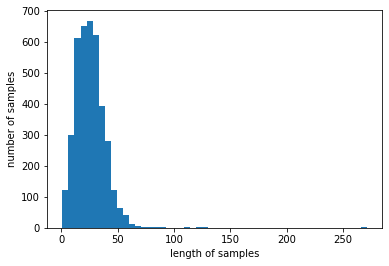

In [56]:
# 전체 데이터의 길이 분포
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [57]:
# 케라스 토크나이저를 통해서 토큰화와 정수 인코딩 진행
# 문장 데이터에 있는 모든 단어를 사용하지 않고 높은 빈도수를 가진 상위 약 4000개의 단어만을 사용

# 토큰화
max_words = 4000
src_tokenizer = Tokenizer(num_words=max_words, oov_token='OOV') #문장 데이터
src_tokenizer.fit_on_texts(sentences)

tar_tokenizer = Tokenizer() #레이블에 해당되는 개체명 태깅 정보
tar_tokenizer.fit_on_texts(ner_tags)

In [58]:
vocab_size = max_words
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 4000
개체명 태깅 정보 집합의 크기 : 47


In [59]:
# 정수 인코딩
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

In [60]:
print(X_train[0])
print(y_train[0])

[1, 3747, 2, 2025, 87, 332, 2, 47, 2406, 3, 132, 28, 7, 2026, 333, 460, 2027, 4]
[3, 3, 8, 10, 6, 7, 8, 21, 13, 4, 1, 2, 4, 7, 1, 3, 10, 9]


In [61]:
# 문장 데이터에 대해서는 일부 단어가 'OOV'로 대체된 상황
# 확인 위해 다시 디코딩(정수->텍스트 데이터) 작업을 함
# 이를 위해 인덱스로부터 단어를 리턴하는 index_to_word를 만듦

index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

In [62]:
# 정수 인코딩 된 첫번째 문장 다시 디코딩
decoded = []
for index in X_train[0]: #첫번째 샘플 안의 인덱스들에 대해서
  decoded.append(index_to_word[index]) #다시 단어로 변환

print('기존 문장 : {}'.format(sentences[0]))
print('빈도수가 낮은 단어가 OOV 처리된 문장 : {}'.format(decoded))

기존 문장 : ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
빈도수가 낮은 단어가 OOV 처리된 문장 : ['OOV', 'vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', '29', '.']


In [63]:
# 샘플들의 모든 길이를 임의 70으로 맞추기
# 케라스의 pad_sequences()

max_len = 70
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

In [64]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state=777)

In [65]:
# 레이블에 해당하는 태깅 정보에 대해서 원-핫 인코딩 수행
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [66]:
# 각 데이터에 대한 크기
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (3131, 70)
훈련 샘플 레이블의 크기 : (3131, 70, 47)
테스트 샘플 문장의 크기 : (783, 70)
테스트 샘플 레이블의 크기 : (783, 70, 47)


#### 4. 양방향 LSTM(Bi-directional LSTM)으로 개체명 인식기 만들기

In [67]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Adam

In [68]:
# 모델
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))

# 패딩을 하느라 숫자 0이 많아질 경우, Embedding()에 mask_zero=Trueㄹ르 설정하여
# 데이터에서 숫자 0은 패딩을 의미하므로 연산에서 제외시킨다는 옵션 줌

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, batch_size=128, epochs=8, validation_data=(X_test, y_test))

Epoch 1/8
88/88 [==============================] - 134s 1s/step - loss: 0.1833 - accuracy: 0.8266 - val_loss: 0.1214 - val_accuracy: 0.8334
Epoch 2/8
88/88 [==============================] - 124s 1s/step - loss: 0.0968 - accuracy: 0.8598 - val_loss: 0.0760 - val_accuracy: 0.8848
Epoch 3/8
88/88 [==============================] - 123s 1s/step - loss: 0.0658 - accuracy: 0.9054 - val_loss: 0.0541 - val_accuracy: 0.9231
Epoch 4/8
88/88 [==============================] - 121s 1s/step - loss: 0.0470 - accuracy: 0.9335 - val_loss: 0.0419 - val_accuracy: 0.9418
Epoch 5/8
88/88 [==============================] - 115s 1s/step - loss: 0.0360 - accuracy: 0.9492 - val_loss: 0.0363 - val_accuracy: 0.9496
Epoch 6/8
88/88 [==============================] - 112s 1s/step - loss: 0.0297 - accuracy: 0.9577 - val_loss: 0.0339 - val_accuracy: 0.9539
Epoch 7/8
88/88 [==============================] - 113s 1s/step - loss: 0.0253 - accuracy: 0.9637 - val_loss: 0.0332 - val_accuracy: 0.9543
Epoch 8/8
88/88 [===

In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

88/88 [==============================] - 13s 148ms/step - loss: 0.0325 - accuracy: 0.9564

 테스트 정확도: 0.9564


In [ ]:
# 실제로 맞추고 있는지를 테스트 데이터를 주고 직접 실제값과 비교
# 앞서 만들어 둔 인덱스로부터 단어와 개체명 태깅 정보를 리턴하는 index_to_word와 index_to_ner을 사용하여
# 테스트 데이터에 대한 예측값과 실제값을 비교 출력

i=10 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t].upper(), index_to_ner[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
sarah            : B-PER   B-PER
brady            : I-PER   I-PER
,                : O       O
whose            : O       O
republican       : B-MISC  B-MISC
husband          : O       O
was              : O       O
OOV              : O       B-PER
OOV              : O       O
in               : O       O
an               : O       O
OOV              : O       O
attempt          : O       O
on               : O       O
president        : O       O
ronald           : B-PER   B-PER
reagan           : I-PER   I-PER
,                : O       O
took             : O       O
centre           : O       O
stage            : O       O
at               : O       O
the              : O       O
democratic       : B-MISC  B-MISC
national         : I-MISC  I-MISC
convention       : I-MISC  I-MISC
on               : O       O
monday           : O       O
night            : O       O
to               : O       O
OOV              : O       O

## 5) BiLSTM을 이용한 개체명 인식 (Named Entity Recognition, NER)
* 개체명 인식 데이터에 대한 전처리 진행, 양방향 LSTM을 이용하여 개체명 인식기 만들고 F1-Score를 사용하여 모델 평가

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import io

#data = pd.read_csv(io.BytesIO(uploaded['ner_dataset.csv'].encode('latin1')))
#data[:5]

data = pd.read_csv('/content/ner_dataset.csv', encoding='latin1')

In [ ]:
data[:5]

'''
Sentence: 1이 있고, Null값이 이어지다가 다시 Sentence: 2가 나오고 Null값이 이어지다가...
이는 하나의 문장을 여러 행으로 나눠놓은 것
숫자값을 t라고 함

'''

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
print('데이터프레임 행의 개수 : {}'.format(len(data)))

데이터프레임 행의 개수 : 226685


In [ ]:
print('데이터에 Null값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null값이 있는지 유무 : True


In [ ]:
print('어떤 열에 Null값이 있는지 출력')
print('==============================')
data.isnull().sum()

어떤 열에 Null값이 있는지 출력


Sentence #    216308
Word               0
POS                0
Tag                1
dtype: int64

In [ ]:
print('sentence # 열의 중복을 제거한 값의 개수 : {}'.format(data['Sentence #'].nunique()))
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))
print('Tag 열의 중복을 제거한 값의 개수 : {}'.format(data.Tag.nunique()))

sentence # 열의 중복을 제거한 값의 개수 : 10377
Word 열의 중복을 제거한 값의 개수 : 16647
Tag 열의 중복을 제거한 값의 개수 : 17


In [ ]:
# 개체명 태깅이 전체 데이터에서 몇 개가 있는지, 개체명 태깅 개수의 분포를 확인

print('Tag 열의 각각의 값의 개수 카운트')
print('================================')
print(data.groupby('Tag').size().reset_index(name='count'))

Tag 열의 각각의 값의 개수 카운트
      Tag   count
0   B-art     120
1   B-eve      90
2   B-geo    7934
3   B-gpe    3731
4   B-nat      56
5   B-org    4215
6   B-per    3710
7   B-tim    4265
8   I-art      68
9   I-eve      72
10  I-geo    1625
11  I-gpe      72
12  I-nat      26
13  I-org    3407
14  I-per    3880
15  I-tim    1295
16      O  192118


In [ ]:
data = data.fillna(method="ffill")

In [ ]:
print(data.tail())

             Sentence #     Word  POS    Tag
226680  Sentence: 10377      and   CC      O
226681  Sentence: 10377      The   DT  B-org
226682  Sentence: 10377  Raiders  NNS  I-org
226683  Sentence: 10377      and   CC      O
226684  Sentence: 10377   singer   NN      O


In [ ]:
# 전체 데이터에 Null 값이 존재하는지 확인
print('데이터에 Null 값이 있는지 유무 : ' + str(data.isnull().values.any()))

데이터에 Null 값이 있는지 유무 : False


In [ ]:
# 모든 단어를 소문자화
data['Word'] = data['Word'].str.lower()
print('Word 열의 중복을 제거한 값의 개수 : {}'.format(data.Word.nunique()))

Word 열의 중복을 제거한 값의 개수 : 15340


In [ ]:
print(data[:5])

    Sentence #           Word  POS Tag
0  Sentence: 1      thousands  NNS   O
1  Sentence: 1             of   IN   O
2  Sentence: 1  demonstrators  NNS   O
3  Sentence: 1           have  VBP   O
4  Sentence: 1        marched  VBN   O


In [ ]:
# 하나의 문장에 등장한 단어와 개체명 태깅 정보끼리 쌍(pair)으로 묶는 작업
func = lambda temp: [(w, t) for w, t in zip(temp['Word'].values.tolist(), temp["Tag"].values.tolist())]
tagged_sentences = [t for t in data.groupby('Sentence #').apply(func)]
print('전체 샘플 개수: {}'.format(len(tagged_sentences)))

전체 샘플 개수: 10377


In [ ]:
print(tagged_sentences[0])

[('thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('london', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('british', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [ ]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences:
  sentence, tag_info = zip(*tagged_sentence)
  sentences.append(list(sentence))
  ner_tags.append(list(tag_info))

In [ ]:
print(sentences[0])
print(ner_tags[0])

['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [ ]:
print(sentences[98])
print(ner_tags[98])

['she', 'had', 'once', 'received', 'a', 'kidney', 'transplant', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


샘플의 최대 길이 : 271
샘플의 평균 길이 : 25.722024


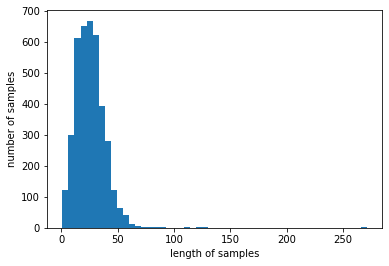

In [46]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [47]:
# 케라스 토크나이저 통해서 정수 인코딩
src_tokenizer = Tokenizer(oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)
tar_tokenizer = Tokenizer(lower=False)
tar_tokenizer.fit_on_texts(ner_tags)

NameError: ignored

In [48]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 11389
개체명 태깅 정보 집합의 크기 : 1


In [49]:
print('단어 OOV의 인덱스 : {}'.format(src_tokenizer.word_index['OOV']))

단어 OOV의 인덱스 : 1


In [72]:
# 정수 인코딩
X_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

In [71]:
X_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

In [70]:
# 모델 훈련 후 결과 확인을 위해 인덱스로부터 단어를 리턴하는 index_to_word
# 뒤에서 사용할 index_to_ner
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

In [ ]:
print(index_to_ner)

{1: 'O', 2: 'B-geo', 3: 'B-tim', 4: 'B-org', 5: 'I-per', 6: 'B-gpe', 7: 'B-per', 8: 'I-org', 9: 'I-geo', 10: 'I-tim', 11: 'B-art', 12: 'B-eve', 13: 'I-gpe', 14: 'I-eve', 15: 'I-art', 16: 'B-nat', 17: 'I-nat', 0: 'PAD'}


In [ ]:
# 첫번째 샘플에 대해서 다시 디코딩
# 정수에서 다시 텍스트 데이터로 변환
decoded = []
for index in X_data[0]:
  decoded.append(index_to_word[index])

print('기존의 문장 : {}'.format(sentences[0]))
print('디코딩 문장 : {}'.format(decoded))

기존의 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
디코딩 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


In [ ]:
max_len = 70
X_data = pad_sequences(X_data, padding='post', maxlen=max_len)
y_data = pad_sequences(y_data, padding='post', maxlen=max_len)

In [ ]:
X_train, X_test, y_train_int, y_test_int = train_test_split(X_data, y_data, test_size=.2, random_state=777)

In [ ]:
# 레이블에 해당하는 태깅 정보에 대해서 원-핫 인코딩 수행
y_train = to_categorical(y_train_int, num_classes=tag_size)
y_test = to_categorical(y_test_int, num_classes=tag_size)

In [ ]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_train_int.shape))
print('훈련 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블(정수 인코딩)의 크기 : {}'.format(y_test_int.shape))
print('테스트 샘플 레이블(원-핫 인코딩)의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (8301, 70)
훈련 샘플 레이블(정수 인코딩)의 크기 : (8301, 70)
훈련 샘플 레이블(원-핫 인코딩)의 크기 : (8301, 70, 18)
테스트 샘플 문장의 크기 : (2076, 70)
테스트 샘플 레이블(정수 인코딩)의 크기 : (2076, 70)
테스트 샘플 레이블(원-핫 인코딩)의 크기 : (2076, 70, 18)


### 2. 양방향 LSTM을 이용한 개체명 인식

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 128, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dense(tag_size, activation=('softmax')))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, batch_size = 128, epochs=6, validation_split=0.1)

Epoch 1/6
59/59 [==============================] - 93s 1s/step - loss: 0.3444 - accuracy: 0.8336 - val_loss: 0.2274 - val_accuracy: 0.8472
Epoch 2/6
59/59 [==============================] - 82s 1s/step - loss: 0.1881 - accuracy: 0.8494 - val_loss: 0.1478 - val_accuracy: 0.8653
Epoch 3/6
59/59 [==============================] - 82s 1s/step - loss: 0.1229 - accuracy: 0.8808 - val_loss: 0.1159 - val_accuracy: 0.8918
Epoch 4/6
59/59 [==============================] - 83s 1s/step - loss: 0.0935 - accuracy: 0.9144 - val_loss: 0.0930 - val_accuracy: 0.9236
Epoch 5/6
59/59 [==============================] - 83s 1s/step - loss: 0.0684 - accuracy: 0.9425 - val_loss: 0.0753 - val_accuracy: 0.9342
Epoch 6/6
59/59 [==============================] - 84s 1s/step - loss: 0.0516 - accuracy: 0.9543 - val_loss: 0.0677 - val_accuracy: 0.9405


In [ ]:
# 확인하고 싶은 테스트용 샘플의 인덱스
i = 13
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원핫 인코딩을 다시 정수인코딩으로 변경함
true = np.argmax(y_test[i], -1) # 원핫 인코딩을 다시 정수 인코딩으로 변경

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
  if w != 0: #PAD값은 제외
    print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
"                : O       O
if               : O       O
these            : O       O
are              : O       O
not              : O       O
good             : O       O
qualities        : O       O
,                : O       O
"                : O       O
he               : O       O
reasoned         : O       O
,                : O       O
"                : O       O
it               : O       O
is               : O       O
folly            : O       O
to               : O       O
claim            : O       O
them             : O       O
.                : O       O
"                : O       O


### 3. F1-Score
* 시퀀스 레이블링 모델 평가할 때 주의할 점
  * 모델의 경우에는 보통 큰 의미를 갖지 않는 레이블 정보가 존재
    * 개체명 인식에서는 그 어떤 개체도 아니라는 의미의 'O' 태깅 존재
      * 이런 정보는 보통 대다수의 레이블을 차지하기 때문에 기존에 사용했던 정확도 평가 방법을 사용하는 것이 적절하지 않을 수 있음
      * 모델이 단 1개의 개체도 맞추지 못하고 전부 'O'으로 예상했을 경우

In [ ]:
true=['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','B-MISC','I-MISC','I-MISC','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O']
predicted=['O'] * len(true)
print(predicted)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
'''
PER, MISC, PER, MISC, PER이라는 총 5개의 개체가 존재함에도 불구하고 
예측값인 predicted는 단 1개의 개체도 맞추지 못한 상황을 시뮬레이션
'''

hit = 0
for t, p in zip(true, predicted):
  if t == p:
    hit += 1 #정답인 경우에만 +1

accuracy = hit/len(true) #정답 개수를 총 개수로 나눈다
print("정확도: {:.1%}".format(accuracy))

정확도: 74.4%


In [ ]:
!pip install seqeval

     |████████████████████████████████| 43 kB 1.2 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=457e0ab3425062985d831bdbf7cc82bd86c5c41907f279d8c296e3849bd7cc0f
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
from seqeval.metrics import classification_report
print(classification_report([true], [predicted]))

'''
이러한 측정 방법을 사용하면 PER과 MISC 두 특정 개체 중에서 
실제 predicted가 맞춘 것은 단 1개도 없는 것을 확인할 수 있음

'''

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         2
         PER       0.00      0.00      0.00         3

   micro avg       0.00      0.00      0.00         5
   macro avg       0.00      0.00      0.00         5
weighted avg       0.00      0.00      0.00         5



/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
true=['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','B-MISC','I-MISC','I-MISC','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O']
predicted=['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O','O']
print(classification_report([true], [predicted]))

              precision    recall  f1-score   support

        MISC       1.00      0.50      0.67         2
         PER       1.00      0.67      0.80         3

   micro avg       1.00      0.60      0.75         5
   macro avg       1.00      0.58      0.73         5
weighted avg       1.00      0.60      0.75         5



### 4. F1-score로 성능 측정하기

In [ ]:
def sequences_to_tag(sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수
  result = []
  for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다
    word_sequence = []
    for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다
      pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0, 0]라면 1의 인덱스인 2를 리턴
      word_sequence.append(index_to_ner[pred_index].replace("PAD", "O")) #PAD는 O으로 변경
      result.append(word_sequence)
  return result

In [ ]:
y_predicted = model.predict([X_test])
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

In [ ]:
from seqeval.metrics import f1_score, classification_report
print(classification_report(test_tags, pred_tags))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00      1050
         eve       0.00      0.00      0.00      1470
         geo       0.77      0.79      0.78    108850
         gpe       0.92      0.84      0.88     48440
         nat       0.00      0.00      0.00       630
         org       0.42      0.50      0.46     59990
         per       0.61      0.62      0.61     49070
         tim       0.75      0.77      0.76     59710

   micro avg       0.69      0.71      0.70    329210
   macro avg       0.43      0.44      0.44    329210
weighted avg       0.69      0.71      0.70    329210



In [ ]:
from seqeval.metrics import f1_score, classification_report
print(classification_report(test_tags, pred_tags))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00      1050
         eve       0.00      0.00      0.00      1470
         geo       0.77      0.79      0.78    108850
         gpe       0.92      0.84      0.88     48440
         nat       0.00      0.00      0.00       630
         org       0.42      0.50      0.46     59990
         per       0.61      0.62      0.61     49070
         tim       0.75      0.77      0.76     59710

   micro avg       0.69      0.71      0.70    329210
   macro avg       0.43      0.44      0.44    329210
weighted avg       0.69      0.71      0.70    329210



## 6) BiLSTM-CRF를 이용한 개체명 인식
* 기존의 양방향 LSTM 모델에 CRF(Conditional Random Field)라는 새로운 층을 추가하여 보다 모델을 개선시킨 **양방향 LSTM + CRF 모델**을 사용하여 개체명 인식(Named Entity Recognition)을 수행

### 1. CRF(Conditional Random Field)
* 양방향 LSTM 모델 위에 하나의 층으로 추가
* 기존의 양방향 LSTM 개체명 인식 모델
  * 각 단어를 **벡터**로 입력받고, **모델의 출력층에서 활성화 함수**를 통해 개체명을 예측
* **양방향 LSTM 위에 CRF 층을 추가하여 얻을 수 있는 이점**
  * CRF 층을 추가하면 모델은 예측 개체명, 다시 말해 **레이블 사이의 의존성**을 고려할 수 있음
    * 기존에는 활성화 함수를 지난 시점에서 개체명 결정, CRF 층을 추가한 모델에서는 **활성화 함수의 결과들이 CRF 층의 입력으로 전달**됨
      * word1에 대한 BiLSTM 셀과 활성화 함수를 지난 출력값은 CRF층의 입력이 됨
      * 마찬가지로 모든 단어에 대한 활성화 함수를 지난 출력값은 CRF층의 입력이 되고, CRF 층은 레이블 시퀀스에 대해서 가장 높은 점수를 가지는 시퀀스를 예측
    * 요약: **양방향 LSTM은 입력 단어에 대한 양방향 문맥을 반영하며, CRF는 출력 레이블에 대한 양방향 문맥을 반영**

In [1]:
!pip install keras-crf

     |████████████████████████████████| 1.1 MB 6.0 MB/s 


In [6]:
import tensorflow as tf

In [4]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, TimeDistributed, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_crf import CRFModel

In [ ]:
# 케라스의 함수형 API를 사용하여 마지막 층에 CRF층 추가
sequence_input = Input(shape=(max_len,),dtype=tf.int32, name='sequence_input')
model_embedding = Embedding(input_dim=vocab_size, output_dim=128, input_len=max_len)(sequence_input)
model_bilstm = Bidirectional(LSTM(units=64, return_sequences=True))(model_embedding)
model_dropout = TimeDistributed(Dropout(0.3))(model_bilstm)
model_Dense = TimeDistributed(Dense(tag_size, activation='relut'))(model_dropout)
base = Model(inputs=sequence_input, outputs=model_dense)
model = CRFModel(base, tag_size)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModlCheckpoint('bilstm_crf/cp.ckpt', monitor='val_decode_sequence_accuracy', mode='max', verbose=1,
                    save_best_only=True, save_weights_only=True)

In [ ]:
# 해당 패키지가 원핫 인코딩 된 레이블은 지원하지 않으므로 y_train이 아니라 y_train_int를 사용함을 주의
history = model.fit(X_train, y_train_int, batch_size=128, epochs=15, validation_split=0.1, callbacks=[mc, es])

In [ ]:
model.load_weights('bilstm_crf/cp.ckpt')

In [ ]:
# 테스트 데이터의 13번 인덱스의 샘플에 대해서 예측
i = 13
y_predicted = model.predict(np.array([X_test[i]]))[0] #입력학 테스트용 샘플에 대해서 예측 y를 리턴
true = np.argmax(y_test[i], -1) #원핫 인코딩을 다시 정수 인코딩으로 변경

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
  if w != 0: #PAD값은 제외
    print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t], index_to_ner[pred]))

In [ ]:
# 테스트 데이터에 대해서 성능 측정. 테스트 데이터에 대한 예측 시쿠너스인 y_predicted 얻음
y_predicted = model.predict(X_test)[0]
print(y_predicted[:2])

In [ ]:
# 정수 시퀀스로 출력되므로 이전에 BiLSTM을 위해 사용했던 함수인 sequences_to_tag를 바로 사용 못해서 변형해야 함
# CRF 층을 사용할 때를 위한 함수로 sequences_to_tag_for_crf를 만듦

def sequences_to_tag_for_crf(sequences): #예측값을 index_to_nef를 사용하여 태깅 정보로 변경하는 함수
  result = []
  for sequence in sequences: #전체 시퀀스로부터 시퀀스를 하나씩 꺼냄
    word_sequence = []
    for pred_index in sequence: #시퀀스로부터 예측값 정수를 하나씩 꺼냄
      word_sequence.append(index_to_ner[pred_index].replace("PAD", "O")) #PAD는 O로 변경
    result.append(word_sequence)
  return result

In [ ]:
# 예측값과 실제값에 대한 태깅 시퀀스

pred_tags = sequences_to_tag_for_crf(y_predicted)
test_tags = sequences_to_tag(y_test)

In [ ]:
# F1-score

from seqeval.metrics import f1_score, classification_report
print(classification_report(test_tags, pred_tags))

In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

## 7) 글자 임베딩(Character Embedding) 활용하기
* 개체명 인식기의 성능을 높이는 방법으로 12챕터에서 배운 글자 임베딩을 워드 임베딩과 함께 입력으로 사용하는 방법이 있음
* 워드 임베딩에 글자 임베딩을 연결(concatenate)하여 성능을 높임


### 1. 글자 임베딩(Char Embedding)을 위한 전처리
* 글자 임베딩을 위해서 하고자 하는 전처리는 글자 단위 정수 인코딩
```
'good book의 정수 인코딩 결과'
[[12 7 7 17]
[21 7 7 11]]
```

* 이 각 정수를 각각 임베딩 층을 거치도록 하여, 글자 단위 임베딩을 얻게 됨
* 임베딩 층은 모델을 설계할 때 추가하게 되므로, 여기서는 정수 인코딩까지만 진행

In [ ]:
from google.colab import files
files.upload()

In [82]:
#import io
#data = pd.read_csv(io.BytesIO(uploaded['ner_dataset.csv'].encode('latin1')))
#data[:5]

import pandas as pd

data = pd.read_csv('/content/ner_dataset.csv', encoding='latin1')

In [83]:
# char_vocab 만들기
words = list(set(data["Word"].values))
chars = set([w_i for w in words for w_i in w])
chars = sorted(list(chars))
print(chars)

['!', '"', '$', '%', '&', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~', '\x85', '\x92', '\x94', '\x96', '\x97', '°', 'é', 'ë', 'ö']


In [84]:
char_to_index = {c: i + 2 for i, c in enumerate(chars)}
char_to_index["OOV"] = 1
char_to_index["PAD"] = 0

In [85]:
index_to_char = {}
for key, value in char_to_index.items():
    index_to_char[value] = key

In [86]:
print(sentences[0])

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']


In [87]:
  max_len_char = 15

  def padding_char_indice(char_indice, max_len_char):
      return pad_sequences(
        char_indice, maxlen=max_len_char, padding='post', 
        value = 0)
    
  def integer_coding(sentences):
      char_data = []
      for ts in sentences:
        word_indice = [word_to_index[t] for t in ts]
        char_indice = [[char_to_index[char] for char in t]  
                                                     for t in ts]
        char_indice = padding_char_indice(char_indice, max_len_char)
    
        for chars_of_token in char_indice:
            if len(chars_of_token) > max_len_char:
                print("최대 단어 길이 초과!")
                continue
        char_data.append(char_indice)
      return char_data

In [ ]:
X_char_data = integer_coding(sentences)

In [ ]:
# 정수 인코딩 이전의 기존 문장
print(sentences[0])

In [ ]:
# 단어 단위 정수 인코딩 + 패딩
print(X_data[0])

In [ ]:
# 글자 단위 정수 인코딩
print(X_char_data[0])

In [ ]:
# 문장 길이 방향으로도 패딩을 해줌
X_char_data = pad_sequences(X_char_data, maxlen=max_len, padding='post', value=0)

In [ ]:
X_char_train, X_char_test, _, _ = train_test_split(X_char_data, y_data, test_size=0.2, random_state=777)
X_char_train = np.array(X_char_train)
X_char_test = np.array(X_char_test)

In [ ]:
print(X_train[0])

In [ ]:
print(index_to_word[150])

In [ ]:
# 그렇다면 X_char_train의 첫번째 훈련 샘플의 첫번째 단어의 글자 정수 인코딩 결과로부터
# soldiers라는 단어와 일치하는지 확인
print(' '.join([index_to_char[index] for index in X_char_train[0][0]]))

In [ ]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('훈련 샘플 char 데이터의 크기 : {}'.format(X_char_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

### 2. BiLSTM-CNN을 이용한 개체명 인식

In [ ]:
from tensorflow.keras.layers import Embedding, TimeDistributed, Dropout, concatenate, Bidirectional, LSTM, Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras import Input, Model
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:
# 단어 임베딩
words_input = Input(shape=(None, ), dtype='int32', name='words_input')
words = Embedding(input_dim = vocab_size, output_dim=128)(words_input)

# char 임베딩
character_input = Input(shape=(None, max_len_char, ), name='char_input')
embed_char_out = TimeDistributed(Embedding(len(char_to_index), 64, embeddings_initializer = RAndomUniform(minival=-0.5, maxval=0.5)), name='char_embedding')(character_input)
dropout = Dropout(0.5)(embed_char_out)

# char 임베딩에 대해서는 Conv1D 수행
conv1d_out = TimeDistributed(Conv1D(kernel_size=3, filters=30, paddings='same', activation='tanh', strides=1))(dropout)
maxpool_out = TimeDistributed(MaxPooling1D(max_len_char))(conv1d_out)
char = TimeDistributed(Flatten())(maxpool_out)
char = Dropout(0.5)(char)

# char 임베딩을 Conv1D 수행한 뒤에 단어 임베딩과 연결
output = concatenate([words, char])

# 연결한 벡터를 가지고 문장의 길이만큼 LSTM 수행
output = Bidirectional(LSTM(256, return_sequences=True, dropout=0.5))(output)

# 출력층
output = TimeDistributed(Dense(tag_size, activation='sortmax'))(output)

model = Model(inputs=[words_input, character_input], outputs=[output])
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['acc'])

In [ ]:
# 조기 종료를 위해서 콜백 정의
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_cnn.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
history = model.fit([X_train, X_char_train], y_train, batch_size = 128, epochs = 15, validation_split = 0.1, verbose = 1, callbacks=[es, mc])

In [ ]:
# 조기 종료로 학습 끝날 시 검증 데이터에 대해서 정확도가 가장 높았을 당시를 저장해둔 가중치 불러오기
model = load_model('bilstm_cnn.h5')

In [ ]:
# 테스트 데이터의 13번 인덱스의 샘플에 대해서 예측

i=13 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict([np.array([X_test[i]]), np.array([X_char_test[i]])]) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴

y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t], index_to_ner[pred]))

In [ ]:
# 테스트 데이터에 대해서 성능 측정
y_predicted = model.predict([X_test, X_char_test])
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(y_test)

In [ ]:
# F1 score를 계산
from seqeval.metrics import f1_score, classification_report
print(classification_report(test_tags, pred_tags))

In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

In [ ]:
### 3. BiLSTM-CNN-CRF

In [ ]:
# 단어 임베딩
words_input = Input(shape=(None,),dtype='int32',name='words_input')
words = Embedding(input_dim = vocab_size, output_dim = 128)(words_input)

# char 임베딩
character_input = Input(shape=(None, max_len_char,),name='char_input')
embed_char_out = TimeDistributed(Embedding(len(char_to_index), 64, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(character_input)
dropout = Dropout(0.5)(embed_char_out)

# char 임베딩에 대해서는 Conv1D 수행
conv1d_out= TimeDistributed(Conv1D(kernel_size=3, filters=30, padding='same',activation='tanh', strides=1))(dropout)
maxpool_out=TimeDistributed(MaxPooling1D(max_len_char))(conv1d_out)
char = TimeDistributed(Flatten())(maxpool_out)
char = Dropout(0.5)(char)

# char 임베딩을 Conv1D 수행한 뒤에 단어 임베딩과 연결
output = concatenate([words, char])

# 연결한 벡터를 가지고 문장의 길이만큼 LSTM을 수행
output = Bidirectional(LSTM(256, return_sequences=True, dropout=0.50))(output)

# 출력층
output = TimeDistributed(Dense(tag_size, activation='relu'))(output)

base = Model(inputs=[words_input, character_input], outputs=[output])

model = CRFModel(base, tag_size)

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              metrics='accuracy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_cnn_crf/cp.ckpt', monitor='val_decode_sequence_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

In [ ]:
# CRF층은 원핫 인코딩 된 레이블은 지원하지 않으므로 y_train_int를 사용해야 함
history = model.fit([X_train, X_char_train], y_train_int, batch_size=128, epochs=15, validation_split=0.1, callbacks=[mc, es])

In [ ]:
# 검증 데이터에 대해서 정확도가 가장 높았을 당시를 저장해둔 가중치 불러오기
model.load_weights('bilstm_cnn_crf/cp.ckpt')

In [ ]:
# 테스트 데이터의 13번 인덱스의 샘플에 대해서 예측
i=13 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict([np.array([X_test[i]]), np.array([X_char_test[i]])])[0] # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t], index_to_ner[pred]))

In [ ]:
# 테스트 데이터에 대해서 성능 측정
y_predicted = model.predict([X_test, X_char_test])[0]
pred_tags = sequences_to_tag_for_crf(y_predicted)
test_tags = sequences_to_tag(y_test)

In [ ]:
# F1-score
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
print(classification_report(test_tags, pred_tags))

In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

### 4. BiLSTM-BiLSTM-CRF
* 1D CNN이 아니라 양방향 LSTM을 통해서 얻을 수 있음
* 양방향 LSTM을 이용해 얻은 글자 임베딩을 워드 임베딩과 연결(concatenate)하여 양방향 LSTM의 입력으로 사용하고, 마지막으로 CRF 층을 추가하여 모델을 만듭
